# PREPROCESSING

This notebook corresponds to the preprocessing step of this project. The goal of this step is to prepare the data for the next steps of the project.

In [9]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from datetime import datetime
from sklearn import preprocessing

In [10]:
data = pd.read_csv('../data/US_Accidents_March23_sampled_500k.csv')

## Section 1: General inspection 

Let's start by looking at the rows and columns of the dataset.

In [11]:
data.shape

(500000, 46)

Let's see the variables in our data and decide which will we our target variable.

In [12]:
data.columns

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

The Start_Time and End_Time variables cause some problems since they are strings and are difficult to compute. In order to avoid further problems we will create a new variable called Elapsed_Time, which will be the difference between End_Time and Start_Time.

In [13]:
data['Start_Time'].isna().sum()

0

In [14]:
data['End_Time'].isna().sum()

0

These two variables do not present any Nan, so we can proceed creating this new variable.

In [15]:
time_elapsed: list[int] = list()

for start_time, end_time in zip(data['Start_Time'], data['End_Time']):

    start_time = start_time.split('.')[0]
    end_time = end_time.split('.')[0]

    start = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
    end = datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S')
    time_elapsed.append((end-start).seconds)

data['Time_Difference'] = pd.DataFrame(time_elapsed)

data['Start_Time'] = pd.to_datetime(data['Start_Time'], errors = 'coerce')
data['End_Time'] = pd.to_datetime(data['End_Time'], errors = 'coerce')

data['Year'] = data['Start_Time'].dt.year
data['Month'] = data['Start_Time'].dt.month
data['Day'] = data['Start_Time'].dt.day
data['Hour'] = data['Start_Time'].dt.hour
data['Weekday'] = data['Start_Time'].dt.weekday

print(data['Day'])

data.shape

0         12
1          3
2         20
3         21
4          4
          ..
499995    15
499996    19
499997    13
499998    15
499999     2
Name: Day, Length: 500000, dtype: int64


(500000, 52)

## Section 2: Dealing with missing values
First of all, let's visualise the missing values in the dataset.

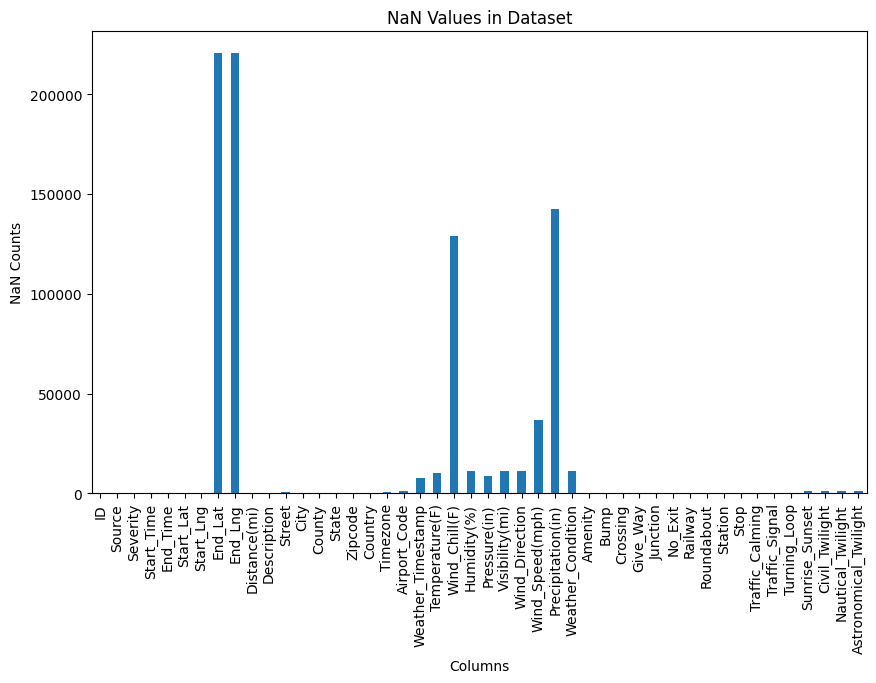

In [5]:
nan_counts = data.isna().sum()
nan_counts.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Columns')
plt.ylabel('NaN Counts')
plt.title('NaN Values in Dataset')
plt.show()

## Section 3: Dealing with outliers

As explained, the target variable is 'Severity', this is how important, the gravity of the accident, in order to predict how does it affect the traffic.

First we take off some variables which we consider may not explain the target. Notice some of these variables are additional information if we alredy have the End_Lat and End_Lng, so we can take them off.

In [16]:
data = data.drop(columns=['ID', 'Source', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 
                          'Weather_Timestamp', 'End_Lat','End_Lng','Airport_Code','Wind_Chill(F)', 'Wind_Direction', 'Wind_Speed(mph)',
                          'Precipitation(in)', 'Weather_Condition', 'Bump', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',])
data.shape

(500000, 29)

## Section 4: Feature selection

## Section 5: Feature extraction

## Section 6: Normalization

In [ ]:
std_scaler = preprocessing.StandardScaler()

## Section 7: Ending preprocessing